<a href="https://colab.research.google.com/github/AndaNet/Zindi-Financial-Inclusion/blob/main/Financial_Inclusion_in_Africa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load Dependencies**

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import io
import collections as clts
import matplotlib.pyplot as plt


from google.colab import files
from io import StringIO
from io import BytesIO
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn import manifold


%matplotlib inline

**Upload Datasets**

In [ ]:
uploaded = files.upload()

Saving SubmissionFile.csv to SubmissionFile.csv
Saving Test_v2.csv to Test_v2.csv
Saving Train_v2.csv to Train_v2.csv
Saving VariableDefinitions.csv to VariableDefinitions.csv


In [ ]:
train_v2 = pd.read_csv(BytesIO(uploaded['Train_v2.csv'])) 
test_v2 = pd.read_csv(BytesIO(uploaded['Test_v2.csv']))

TestSet = test_v2.copy()
TestSet["uniqueid"] = TestSet["uniqueid"] +" x " +TestSet["country"]


In [ ]:

train.loc[:, "kfold"] = -1
train = train.sample(frac=1).reset_index(drop=True)

y = train.bank_account.values
skf = StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(skf.split(X=train, y=y)):
        train.loc[v_, 'kfold'] = f

train.to_csv("train_folds.csv", index=False)

**Exploratory Data Analysis**


In [ ]:
train_v2.dtypes

country                   object
year                       int64
uniqueid                  object
bank_account              object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
dtype: object

In [ ]:
def duplicate(df):
  if df.duplicated().unique() == False:
    print("Data has "+ "\033[1m" +"NO"+"\033[0m"+" duplicating feature vector")
  else:
    print("Data has  duplicating feature vector")

duplicate(train_v2)


Data has NO duplicating feature vector


In [ ]:
def null_count(df, column_name):
  return df[col].isnull().sum()


    

for col in df.columns:
  print(f'{col}:{null_count(df,col)}')



country:0
bank_account:0
location_type:0
cellphone_access:0
household_size:0
age_of_respondent:0
gender_of_respondent:0
relationship_with_head:0
marital_status:0
education_level:0
job_type:0
kfold:0


In [ ]:
def category_not_found(df1, df2, column_name):
  try:
    listCat = []
    for category in df2[column_name].unique():
      if category not in df1[column_name].unique():
        listCat.append(category)          
    return  listCat       
  except ValueError:
    raise ValueError("ValueError exception thrown")   


for col in TestSet.columns:
  print(f'{col}:{category_not_found(train_v2,TestSet,col )}')   



In [ ]:
def unique_value(df,column_name):
  return  (df[column_name].unique())
   


for col in train_v2.columns:
  print(f'{col}:{unique_value(train_v2,col )}')   



In [ ]:
def count_unique_value(df,column_name):
  return  np.asarray(df[column_name].value_counts())
   


for col in train_v2.columns:
    print(f'{col}:{count_unique_value(train_v2,col )}')  





In [ ]:
def calc_mean_mode(df, column_name):
  try:
    if df.dtypes[column_name]==np.object :
      return df[column_name].mode()[0]
    else:
      return round(df[column_name].mean(),2)
  except ValueError:
    raise ValueError("ValueError exception thrown")

for col in train_v2.columns:
   print(f'{col}: {calc_mean_mode(train_v2,col)}')   
  
  


country: 0.14
year: 2016.98
uniqueid: uniqueid_1
bank_account: 0.14
location_type: 0.14
cellphone_access: 0.14
household_size: 3.8
age_of_respondent: 38.81
gender_of_respondent: 0.14
relationship_with_head: 0.14
marital_status: 0.14
education_level: 0.14
job_type: 0.14


In [ ]:
def bankability_likelihood(df,column_name,target_column, boolean_operator, value):
  if boolean_operator == '>':
    return np.round(df.loc[(df[target_column] == 'Yes') & (df[column_name] > int(value)),target_column].count()/df.loc[(df[column_name]) > int(value),target_column].count(),2)    
  elif boolean_operator == '<':
    return np.round(df.loc[(df[target_column] == 'Yes') & (df[column_name] < int(value)),target_column].count()/df.loc[(df[column_name]) < int(value),target_column].count(),2)
  elif boolean_operator == '==':       
    return np.round(df.loc[(df[target_column] == 'Yes') & (df[column_name] == int(value)),target_column].count()/df.loc[(df[column_name]) == int(value),target_column].count(),2)

bankability_likelihood(train_v2)


    

In [ ]:
def conditional_impute(input_df, choice='median'):
    for col in input_df.columns:
      if  input_df.dtypes[col]!=np.object:
        if choice == 'mean':         
          input_df[col]=input_df[col].fillna((input_df[col].dropna().mean()))
        elif choice=='median':
          print(f'Median : {input_df[col].median()}')
          input_df[col]=input_df[col].fillna((input_df[col].dropna().median()))
        else:
            raise ValueError("Invalid choice %s" % repr(choice))


    # your code here
    return input_df


In [ ]:
x = train_v2.loc[((train_v2['job_type'] == 'Formally employed Private') |  (train_v2['job_type'] == 'Formally employed Pens')) & (train_v2['country'] == 'Uganda')]

def plot_single_countplot(df, column_name):
  ax = sns.countplot(x=df[column_name], data=df)


plot_single_countplot(x,'bank_account' )




In [ ]:
x = train_v2.loc[(train_v2['job_type'] == 'Formally employed Private') &  (train_v2['job_type'] == 'Formally employed Government') & (train_v2['country'] == 'Tanzania')]

In [ ]:
x = train_v2.loc[ (train_v2['cellphone_access'] == 'Yes') & (train_v2['country'] == 'Tanzania') &  ]
plot_single_countplot(x,'gender_of_respondent' )

In [ ]:
plt.figure(figsize=(25,10)) # this creates a figure 8 inch wide, 4 inch high

x = train_v2.loc[ (train_v2['cellphone_access'] == 'Yes') ]
plot_single_countplot(x,'job_type' )

plt.show()



In [ ]:
plt.figure(figsize=(25,10)) # this creates a figure 8 inch wide, 4 inch high

x = train_v2.loc[ (train_v2['bank_account'] == 'Yes') ]
plot_single_countplot(x,y,'job_type' )

plt.show()




In [ ]:
plt.figure(figsize=(25,10)) # this creates a figure 8 inch wide, 4 inch high

x = train_v2.loc[ (train_v2['bank_account'] == 'Yes') ]
plot_single_countplot(x,'country' )

plt.show()




In [ ]:
x = train_v2.loc[ (train_v2['gender_of_respondent'] == 'Female') & (train_v2['bank_account'] == 'No')]

def plot_single_boxenplot(df,target_vector, column_name):
  plt.figure(figsize=(15,5))
  plt.subplot(1, 2, 1)
  sns.boxenplot(df[target_vector], train_v2[column_name])
  plt.show()


plot_single_boxenplot(x,'bank_account','age_of_respondent')



In [ ]:
x = train_v2.loc[(train_v2['age_of_respondent']> 26) & (train_v2['age_of_respondent']< 49) & (train_v2['bank_account'] == 'No')]

In [ ]:

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.boxenplot(train_v2['cellphone_access'], train_v2['age_of_respondent']> 21 &, hue=train_v2['bank_account'])
plt.subplot(1, 2, 2)
sns.boxenplot(train_v2['gender_of_respondent'], train_v2['age_of_respondent'], hue=train_v2['bank_account'])
plt.show()


grid = sns.FacetGrid(train_v2, row='cellphone_access', col='gender_of_respondent', height=2.0, aspect=3.0)
grid.map(plt.hist, 'age_of_respondent', bins=30)
grid.add_l/\[/egend()
plt.show()


In [ ]:
TestSet.dtypes

country                   object
year                       int64
uniqueid                  object
location_type             object
cellphone_access          object
household_size             int64
age_of_respondent          int64
gender_of_respondent      object
relationship_with_head    object
marital_status            object
education_level           object
job_type                  object
dtype: object

In [ ]:
TestSet.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056 x Kenya,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060 x Kenya,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065 x Kenya,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072 x Kenya,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073 x Kenya,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [ ]:
train_v2.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


**Feature Engineering**

In [ ]:
len(train_v2[train_v2['country']=='Kenya'])
bank_account_map = {'Yes':1, 'No':0}
train_v2.replace({"bank_account":bank_account_map},inplace=True)
train_v2.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,0,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,1,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,0,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,0,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [ ]:
train_v2['age_of_respondent'] = np.array(np.floor( np.array(train_v2['age_of_respondent']) / 10.))
test_v2['age_of_respondent']= np.array(np.floor( np.array(test_v2['age_of_respondent']) / 10.))
train_v2['household_size'] = np.array(np.floor( np.array(train_v2['household_size']) / 4.))
test_v2['household_size']= np.array(np.floor( np.array(test_v2['household_size']) / 4.))



In [ ]:

test_v2['country']=test_v2['country'].map(train_v2[train_v2['bank_account']== 1].groupby('country').agg('count').sort_values(by='location_type',ascending=False)['location_type'])/test_v2['country'].map(train_v2.groupby('country').agg('count').sort_values(by='location_type',ascending=False)['location_type'])
test_v2['location_type']=test_v2['location_type'].map(train_v2[train_v2['bank_account']== 1].groupby('location_type').agg('count').sort_values(by='country',ascending=False)['country'])/test_v2['location_type'].map(train_v2.groupby('location_type').agg('count').sort_values(by='country',ascending=False)['country'])
test_v2['cellphone_access']=test_v2['cellphone_access'].map(train_v2[train_v2['bank_account']== 1].groupby('cellphone_access').agg('count').sort_values(by='country',ascending=False)['country'])/test_v2['cellphone_access'].map(train_v2.groupby('cellphone_access').agg('count').sort_values(by='country',ascending=False)['country'])
test_v2['gender_of_respondent']=test_v2['gender_of_respondent'].map(train_v2[train_v2['bank_account']== 1].groupby('gender_of_respondent').agg('count').sort_values(by='country',ascending=False)['country'])/test_v2['gender_of_respondent'].map(train_v2.groupby('gender_of_respondent').agg('count').sort_values(by='country',ascending=False)['country'])
test_v2['relationship_with_head']=test_v2['relationship_with_head'].map(train_v2[train_v2['bank_account']== 1].groupby('relationship_with_head').agg('count').sort_values(by='country',ascending=False)['country'])/test_v2['relationship_with_head'].map(train_v2.groupby('relationship_with_head').agg('count').sort_values(by='country',ascending=False)['country'])
test_v2['education_level']=test_v2['education_level'].map(train_v2[train_v2['bank_account']== 1].groupby('education_level').agg('count').sort_values(by='country',ascending=False)['country'])/test_v2['education_level'].map(train_v2.groupby('education_level').agg('count').sort_values(by='country',ascending=False)['country'])
test_v2['job_type']=test_v2['job_type'].map(train_v2[train_v2['bank_account']== 1].groupby('job_type').agg('count').sort_values(by='country',ascending=False)['country'])/test_v2['job_type'].map(train_v2.groupby('job_type').agg('count').sort_values(by='country',ascending=False)['country'])
test_v2['marital_status']=test_v2['marital_status'].map(train_v2[train_v2['bank_account']== 1].groupby('marital_status').agg('count').sort_values(by='country',ascending=False)['country'])/test_v2['marital_status'].map(train_v2.groupby('marital_status').agg('count').sort_values(by='country',ascending=False)['country'])
test_v2['age_of_respondent']=test_v2['age_of_respondent'].map(train_v2[train_v2['bank_account']== 1].groupby('age_of_respondent').agg('count').sort_values(by='country',ascending=False)['country'])/test_v2['age_of_respondent'].map(train_v2.groupby('age_of_respondent').agg('count').sort_values(by='country',ascending=False)['country'])
test_v2['household_size']=test_v2['household_size'].map(train_v2[train_v2['bank_account']== 1].groupby('household_size').agg('count').sort_values(by='country',ascending=False)['country'])/test_v2['household_size'].map(train_v2.groupby('household_size').agg('count').sort_values(by='country',ascending=False)['country'])


test_v2.head(10)


,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0.250659,2018,uniqueid_6056,0.178739,0.183797,0.144355,0.173591,0.189696,0.177149,0.173598,0.232773,0.775194
1,0.250659,2018,uniqueid_6060,0.178739,0.183797,0.140690,0.160960,0.189696,0.177149,0.173598,0.570361,0.541232
2,0.250659,2018,uniqueid_6065,0.116503,0.017133,0.144355,0.113353,0.106795,0.059853,0.173598,0.038981,0.094974
3,0.250659,2018,uniqueid_6072,0.116503,0.017133,0.140690,0.173591,0.106795,0.177149,0.173598,0.085451,0.094974
4,0.250659,2018,uniqueid_6073,0.178739,0.017133,0.144355,0.032096,0.189696,0.086586,0.121007,0.232773,0.094974
5,0.250659,2018,uniqueid_6074,0.116503,0.183797,0.140690,0.135711,0.106795,0.106595,0.173598,0.085451,0.131738
6,0.250659,2018,uniqueid_6075,0.116503,0.183797,0.140690,0.173591,0.106795,0.177149,0.112717,0.085451,0.079507
7,0.250659,2018,uniqueid_6076,0.178739,0.183797,0.144355,0.135711,0.106795,0.106595,0.173598,0.570361,0.131738
8,0.250659,2018,uniqueid_6077,0.116503,0.183797,0.140690,0.135711,0.106795,0.086586,0.121007,0.085451,0.079507
9,0.250659,2018,uniqueid_6078,0.178739,0.183797,0.144355,0.168296,0.189696,0.177149,0.112717,0.232773,0.116706


In [ ]:

train_v2['country']=train_v2['country'].map(train_v2[train_v2['bank_account']== 1].groupby('country').agg('count').sort_values(by='location_type',ascending=False)['location_type'])/train_v2['country'].map(train_v2.groupby('country').agg('count').sort_values(by='location_type',ascending=False)['location_type'])
train_v2['location_type']=train_v2['location_type'].map(train_v2[train_v2['bank_account']== 1].groupby('location_type').agg('count').sort_values(by='country',ascending=False)['country'])/train_v2['location_type'].map(train_v2.groupby('location_type').agg('count').sort_values(by='country',ascending=False)['country'])
train_v2['cellphone_access']=train_v2['cellphone_access'].map(train_v2[train_v2['bank_account']== 1].groupby('cellphone_access').agg('count').sort_values(by='country',ascending=False)['country'])/train_v2['cellphone_access'].map(train_v2.groupby('cellphone_access').agg('count').sort_values(by='country',ascending=False)['country'])
train_v2['gender_of_respondent']=train_v2['gender_of_respondent'].map(train_v2[train_v2['bank_account']== 1].groupby('gender_of_respondent').agg('count').sort_values(by='country',ascending=False)['country'])/train_v2['gender_of_respondent'].map(train_v2.groupby('gender_of_respondent').agg('count').sort_values(by='country',ascending=False)['country'])
train_v2['relationship_with_head']=train_v2['relationship_with_head'].map(train_v2[train_v2['bank_account']== 1].groupby('relationship_with_head').agg('count').sort_values(by='country',ascending=False)['country'])/train_v2['relationship_with_head'].map(train_v2.groupby('relationship_with_head').agg('count').sort_values(by='country',ascending=False)['country'])
train_v2['education_level']=train_v2['education_level'].map(train_v2[train_v2['bank_account']== 1].groupby('education_level').agg('count').sort_values(by='country',ascending=False)['country'])/train_v2['education_level'].map(train_v2.groupby('education_level').agg('count').sort_values(by='country',ascending=False)['country'])
train_v2['job_type']=train_v2['job_type'].map(train_v2[train_v2['bank_account']== 1].groupby('job_type').agg('count').sort_values(by='country',ascending=False)['country'])/train_v2['job_type'].map(train_v2.groupby('job_type').agg('count').sort_values(by='country',ascending=False)['country'])
train_v2['marital_status']=train_v2['marital_status'].map(train_v2[train_v2['bank_account']== 1].groupby('marital_status').agg('count').sort_values(by='country',ascending=False)['country'])/train_v2['marital_status'].map(train_v2.groupby('marital_status').agg('count').sort_values(by='country',ascending=False)['country'])
train_v2['age_of_respondent']=train_v2['age_of_respondent'].map(train_v2[train_v2['bank_account']== 1].groupby('age_of_respondent').agg('count').sort_values(by='country',ascending=False)['country'])/train_v2['age_of_respondent'].map(train_v2.groupby('age_of_respondent').agg('count').sort_values(by='country',ascending=False)['country'])
train_v2['household_size']=train_v2['household_size'].map(train_v2[train_v2['bank_account']== 1].groupby('household_size').agg('count').sort_values(by='country',ascending=False)['country'])/train_v2['household_size'].map(train_v2.groupby('household_size').agg('count').sort_values(by='country',ascending=False)['country'])

train_v2.head(10)



,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0.250659,2018,uniqueid_1,1,0.116503,0.183797,0.144355,0.135711,0.106795,0.106595,0.173598,0.232773,0.131738
1,0.250659,2018,uniqueid_2,0,0.116503,0.017133,0.140690,0.113353,0.106795,0.177149,0.090103,0.038981,0.202429
2,0.250659,2018,uniqueid_3,1,0.178739,0.183797,0.140690,0.135711,0.189696,0.098802,0.121007,0.570361,0.131738
3,0.250659,2018,uniqueid_4,0,0.116503,0.183797,0.140690,0.173591,0.106795,0.177149,0.173598,0.085451,0.541232
4,0.250659,2018,uniqueid_5,0,0.178739,0.017133,0.112163,0.135711,0.189696,0.086586,0.121007,0.085451,0.079507
5,0.250659,2018,uniqueid_6,0,0.116503,0.017133,0.140690,0.135711,0.106795,0.106595,0.173598,0.085451,0.079507
6,0.250659,2018,uniqueid_7,0,0.116503,0.183797,0.140690,0.173591,0.106795,0.106595,0.173598,0.085451,0.131738
7,0.250659,2018,uniqueid_8,0,0.116503,0.183797,0.144355,0.168296,0.106795,0.177149,0.173598,0.510804,0.775194
8,0.250659,2018,uniqueid_9,1,0.116503,0.183797,0.144355,0.160960,0.189696,0.177149,0.173598,0.232773,0.116706
9,0.250659,2018,uniqueid_10,0,0.178739,0.183797,0.144355,0.113353,0.106795,0.177149,0.112717,0.038981,0.094974


In [ ]:
encoded_df = pd.get_dummies(train_v2.drop(columns=['uniqueid','year']))
encoded_df.head()

,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0.250659,1,0.116503,0.183797,0.144355,0.135711,0.106795,0.106595,0.173598,0.232773,0.131738
1,0.250659,0,0.116503,0.017133,0.140690,0.113353,0.106795,0.177149,0.090103,0.038981,0.202429
2,0.250659,1,0.178739,0.183797,0.140690,0.135711,0.189696,0.098802,0.121007,0.570361,0.131738
3,0.250659,0,0.116503,0.183797,0.140690,0.173591,0.106795,0.177149,0.173598,0.085451,0.541232
4,0.250659,0,0.178739,0.017133,0.112163,0.135711,0.189696,0.086586,0.121007,0.085451,0.079507


In [ ]:
encoded_df.shape

conditional_impute(encoded_df,'mean')

,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0.250659,1,0.116503,0.183797,0.144355,0.135711,0.106795,0.106595,0.173598,0.232773,0.131738
1,0.250659,0,0.116503,0.017133,0.140690,0.113353,0.106795,0.177149,0.090103,0.038981,0.202429
2,0.250659,1,0.178739,0.183797,0.140690,0.135711,0.189696,0.098802,0.121007,0.570361,0.131738
3,0.250659,0,0.116503,0.183797,0.140690,0.173591,0.106795,0.177149,0.173598,0.085451,0.541232
4,0.250659,0,0.178739,0.017133,0.112163,0.135711,0.189696,0.086586,0.121007,0.085451,0.079507
...,...,...,...,...,...,...,...,...,...,...,...
23519,0.086149,0,0.116503,0.183797,0.140690,0.168296,0.106795,0.177149,0.112717,0.038981,0.181481
23520,0.086149,0,0.116503,0.183797,0.144355,0.135711,0.106795,0.177149,0.121007,0.232773,0.181481
23521,0.086149,0,0.116503,0.183797,0.140690,0.135711,0.106795,0.059853,0.090103,0.085451,0.181481
23522,0.086149,0,0.178739,0.183797,0.140690,0.173591,0.106795,0.059853,0.112717,0.232773,0.131738


In [ ]:
    encoded_df.loc[:, "kfold"] = -1
    encoded_df = encoded_df.sample(frac=1).reset_index(drop=True)

    y = encoded_df.bank_account.values
    skf = StratifiedKFold(n_splits=5)

    for f, (t_, v_) in enumerate(skf.split(X=encoded_df, y=y)):
        encoded_df.loc[v_, 'kfold'] = f

    encoded_df.to_csv("train_folds.csv", index=False)

In [ ]:
df = pd.read_csv("train_folds.csv") 
conditional_impute(df,'mean')



,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,kfold
0,0.250659,1,0.116503,0.183797,0.140690,0.168296,0.189696,0.177149,0.173598,0.232773,0.116706,0
1,0.114825,0,0.178739,0.183797,0.140690,0.173591,0.106795,0.177149,0.112717,0.038981,0.116706,0
2,0.250659,0,0.116503,0.183797,0.140690,0.135711,0.106795,0.106595,0.173598,0.232773,0.116706,0
3,0.250659,0,0.116503,0.183797,0.144355,0.168296,0.106795,0.106595,0.173598,0.085451,0.079507,0
4,0.250659,0,0.178739,0.183797,0.140690,0.168296,0.189696,0.177149,0.173598,0.232773,0.079507,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23519,0.086149,0,0.178739,0.183797,0.140690,0.135711,0.106795,0.059853,0.121007,0.085451,0.020734,4
23520,0.086149,0,0.116503,0.183797,0.140690,0.173591,0.106795,0.177149,0.112717,0.232773,0.131738,4
23521,0.250659,0,0.116503,0.183797,0.112163,0.168296,0.189696,0.177149,0.173598,0.085451,0.131738,4
23522,0.086149,0,0.116503,0.017133,0.140690,0.168296,0.106795,0.106595,0.173598,0.085451,0.131738,4


fold=0,auc= 0.8591157145280381
None
fold=1,auc= 0.8711240867621708
None
fold=2,auc= 0.8577039501523595
None
fold=3,auc= 0.8454955993739939
None
fold=4,auc= 0.8538517768864984
None
(23524, 13)


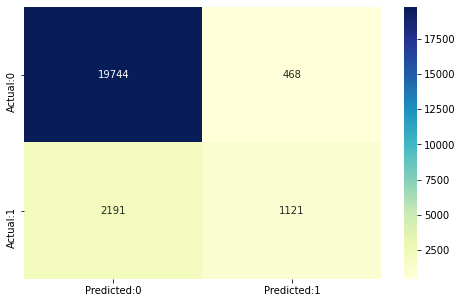

In [ ]:
dfs= []
for j in range(5):   

    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)


    xtrain = df_train.drop(['bank_account'], axis=1)
    xvalid = df_valid.drop(['bank_account'], axis=1)

    ytrain = df_train.bank_account.values
    yvalid = df_valid.bank_account.values

    model = XGBClassifier()
    model.fit(xtrain, ytrain)
    
    y_pred = model.predict_proba(xvalid)[:, 1]

    auc = roc_auc_score(yvalid, y_pred)
    print(f"fold={fold},auc= {auc}")

    df_valid.loc[:, "lr_pred"] = np.where(y_pred>.5,1,0) 

    temp_df =  df_valid
    dfs.append(temp_df)



fin_valid_df = pd.concat(dfs)
print(fin_valid_df.shape)
fin_valid_df.to_csv("fin_valid_df.csv")

   

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(fin_valid_df.bank_account.values,np.where(fin_valid_df.lr_pred.values>.5,1,0))
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");    

In [ ]:
model

'None'

In [ ]:
fin_valid_df

,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,kfold,lr_pred
0,0.114825,0,0.116503,0.183797,0.140798,0.140822,0.189696,0.177149,0.173598,0.085451,0.079507,0,0.093339
1,0.114825,0,0.116503,0.183797,0.140798,0.140822,0.106795,0.086586,0.121007,0.232773,0.094974,0,0.066037
2,0.091692,0,0.178739,0.017133,0.140798,0.140822,0.189696,0.059853,0.112717,0.085451,0.131738,0,0.009530
3,0.091692,0,0.178739,0.017133,0.140798,0.140822,0.106795,0.086586,0.173598,0.038981,0.131738,0,0.004327
4,0.114825,0,0.178739,0.183797,0.140798,0.140822,0.106795,0.106595,0.173598,0.085451,0.079507,0,0.117855
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4699,0.091692,0,0.178739,0.017133,0.140798,0.140822,0.106795,0.106595,0.121007,0.085451,0.131738,4,0.006341
4700,0.250659,0,0.116503,0.183797,0.140798,0.140822,0.106795,0.177149,0.090103,0.085451,0.116706,4,0.152046
4701,0.091692,0,0.178739,0.183797,0.140798,0.140822,0.106795,0.106595,0.121007,0.038981,0.131738,4,0.024553
4702,0.091692,0,0.178739,0.183797,0.140798,0.140822,0.189696,0.177149,0.121007,0.085451,0.131738,4,0.092735


In [ ]:
df

,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,kfold
0,0.114825,0,0.116503,0.183797,0.140798,0.140822,0.189696,0.177149,0.173598,0.085451,0.079507,0
1,0.114825,0,0.116503,0.183797,0.140798,0.140822,0.106795,0.086586,0.121007,0.232773,0.094974,0
2,0.091692,0,0.178739,0.017133,0.140798,0.140822,0.189696,0.059853,0.112717,0.085451,0.131738,0
3,0.091692,0,0.178739,0.017133,0.140798,0.140822,0.106795,0.086586,0.173598,0.038981,0.131738,0
4,0.114825,0,0.178739,0.183797,0.140798,0.140822,0.106795,0.106595,0.173598,0.085451,0.079507,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23519,0.091692,0,0.178739,0.017133,0.140798,0.140822,0.106795,0.106595,0.121007,0.085451,0.131738,4
23520,0.250659,0,0.116503,0.183797,0.140798,0.140822,0.106795,0.177149,0.090103,0.085451,0.116706,4
23521,0.091692,0,0.178739,0.183797,0.140798,0.140822,0.106795,0.106595,0.121007,0.038981,0.131738,4
23522,0.091692,0,0.178739,0.183797,0.140798,0.140822,0.189696,0.177149,0.121007,0.085451,0.131738,4


In [ ]:
fin_valid_df

,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,kfold,lr_pred
0,0.114825,0,0.116503,0.183797,0.140798,0.140822,0.189696,0.177149,0.173598,0.085451,0.079507,0,0.093339
1,0.114825,0,0.116503,0.183797,0.140798,0.140822,0.106795,0.086586,0.121007,0.232773,0.094974,0,0.066037
2,0.091692,0,0.178739,0.017133,0.140798,0.140822,0.189696,0.059853,0.112717,0.085451,0.131738,0,0.009530
3,0.091692,0,0.178739,0.017133,0.140798,0.140822,0.106795,0.086586,0.173598,0.038981,0.131738,0,0.004327
4,0.114825,0,0.178739,0.183797,0.140798,0.140822,0.106795,0.106595,0.173598,0.085451,0.079507,0,0.117855
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4699,0.091692,0,0.178739,0.017133,0.140798,0.140822,0.106795,0.106595,0.121007,0.085451,0.131738,4,0.006341
4700,0.250659,0,0.116503,0.183797,0.140798,0.140822,0.106795,0.177149,0.090103,0.085451,0.116706,4,0.152046
4701,0.091692,0,0.178739,0.183797,0.140798,0.140822,0.106795,0.106595,0.121007,0.038981,0.131738,4,0.024553
4702,0.091692,0,0.178739,0.183797,0.140798,0.140822,0.189696,0.177149,0.121007,0.085451,0.131738,4,0.092735


In [ ]:
encoded_df_test = pd.get_dummies(test_v2.drop(columns=['uniqueid','year']))
conditional_impute(encoded_df_test,'mean')
encoded_df_test.head()

,country,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0.250659,0.178739,0.183797,0.144355,0.173591,0.189696,0.177149,0.173598,0.232773,0.775194
1,0.250659,0.178739,0.183797,0.140690,0.160960,0.189696,0.177149,0.173598,0.570361,0.541232
2,0.250659,0.116503,0.017133,0.144355,0.113353,0.106795,0.059853,0.173598,0.038981,0.094974
3,0.250659,0.116503,0.017133,0.140690,0.173591,0.106795,0.177149,0.173598,0.085451,0.094974
4,0.250659,0.178739,0.017133,0.144355,0.032096,0.189696,0.086586,0.121007,0.232773,0.094974


In [ ]:
test_v2

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent
...,...,...,...,...,...,...,...,...,...,...,...,...
10081,Uganda,2018,uniqueid_2998,Rural,No,2,62,Female,Spouse,Married/Living together,Primary education,Self employed
10082,Uganda,2018,uniqueid_2999,Urban,Yes,8,42,Male,Head of Household,Married/Living together,Primary education,Self employed
10083,Uganda,2018,uniqueid_3000,Urban,Yes,1,39,Male,Head of Household,Single/Never Married,Secondary education,Other Income
10084,Uganda,2018,uniqueid_3001,Rural,Yes,6,28,Female,Spouse,Married/Living together,Primary education,Self employed


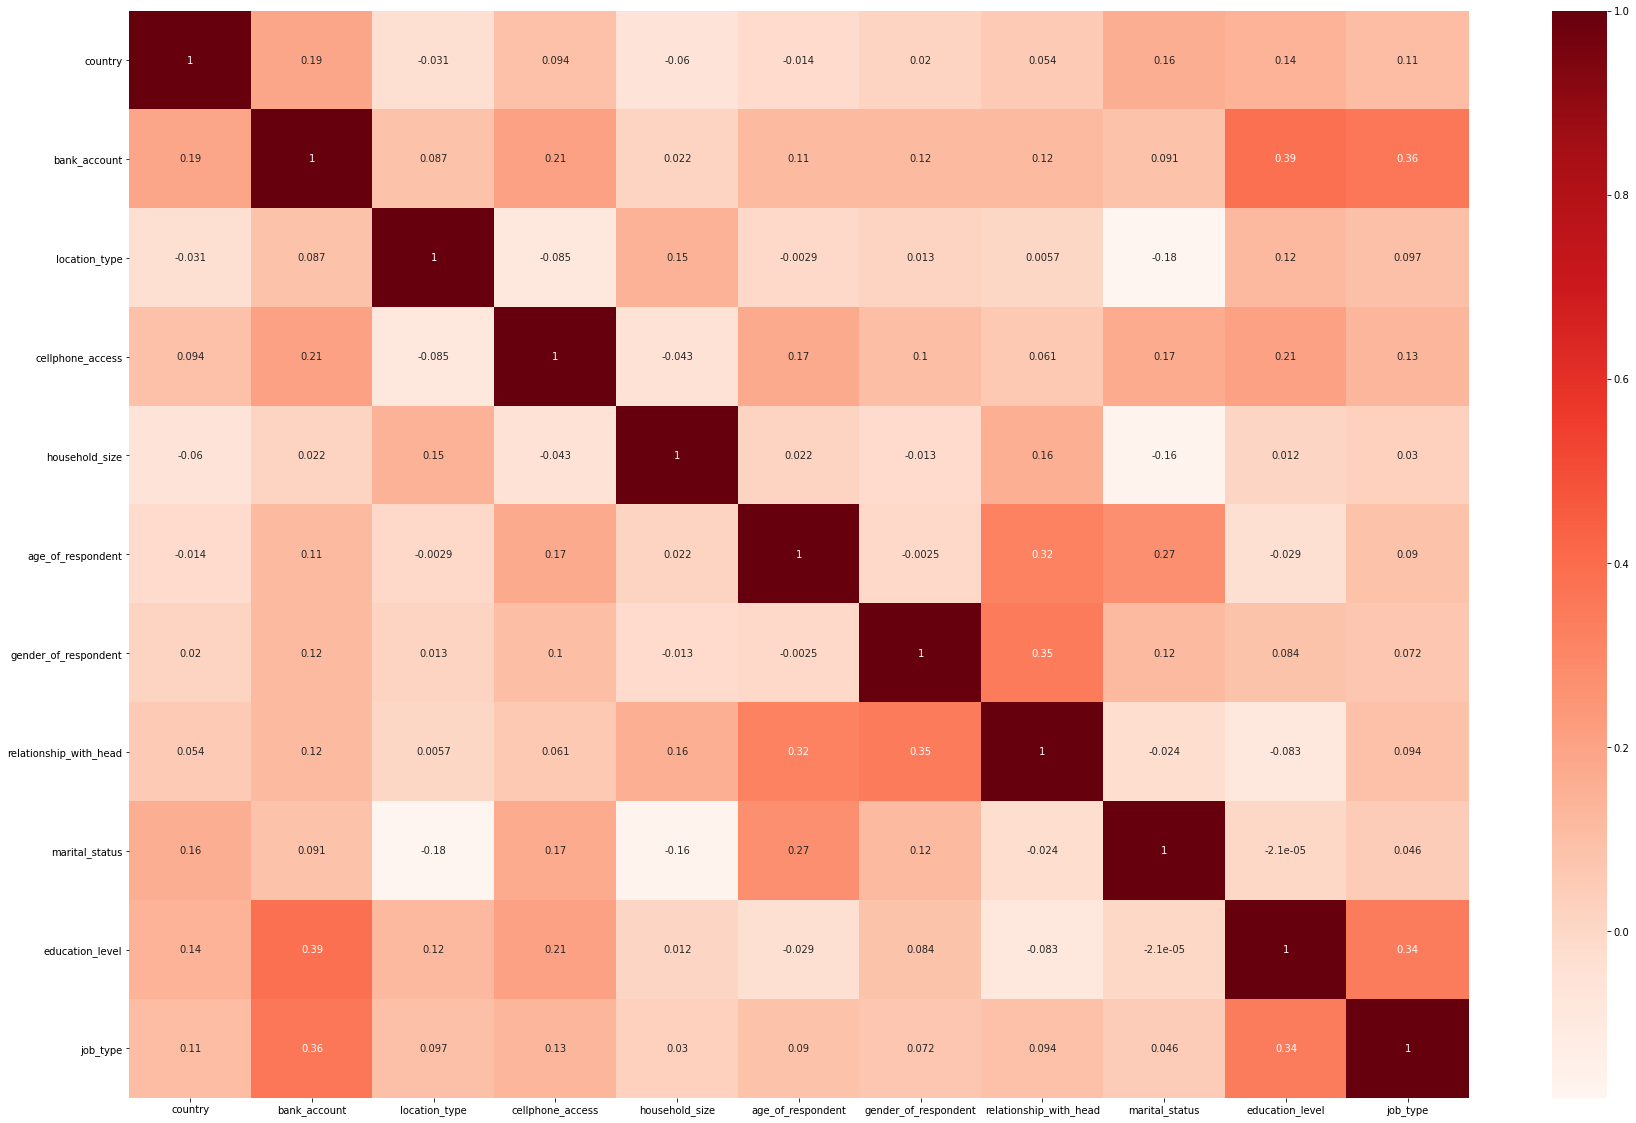

In [ ]:
#Display Pearson correlation HeatMap for all variables
plt.figure(figsize=(30,20))
cor = encoded_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

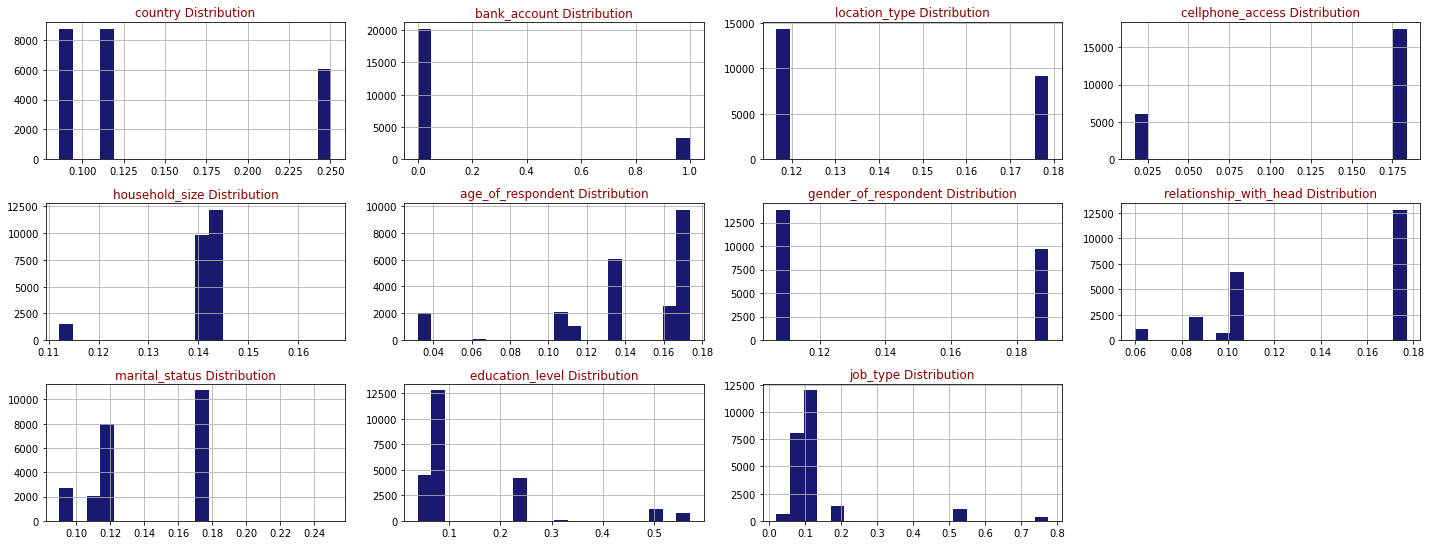

In [ ]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        #ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()
draw_histograms(encoded_df,encoded_df.columns,8,4)

In [ ]:
X = encoded_df.drop(['bank_account','kfold'], axis=1)
y = encoded_df['bank_account'].values.reshape(-1, 1)

In [ ]:
X

,country,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,kfold
0,0.250659,0.116503,0.183797,0.140690,0.168296,0.189696,0.177149,0.173598,0.232773,0.116706,0
1,0.114825,0.178739,0.183797,0.140690,0.173591,0.106795,0.177149,0.112717,0.038981,0.116706,0
2,0.250659,0.116503,0.183797,0.140690,0.135711,0.106795,0.106595,0.173598,0.232773,0.116706,0
3,0.250659,0.116503,0.183797,0.144355,0.168296,0.106795,0.106595,0.173598,0.085451,0.079507,0
4,0.250659,0.178739,0.183797,0.140690,0.168296,0.189696,0.177149,0.173598,0.232773,0.079507,0
...,...,...,...,...,...,...,...,...,...,...,...
23519,0.086149,0.178739,0.183797,0.140690,0.135711,0.106795,0.059853,0.121007,0.085451,0.020734,4
23520,0.086149,0.116503,0.183797,0.140690,0.173591,0.106795,0.177149,0.112717,0.232773,0.131738,4
23521,0.250659,0.116503,0.183797,0.112163,0.168296,0.189696,0.177149,0.173598,0.085451,0.131738,4
23522,0.086149,0.116503,0.017133,0.140690,0.168296,0.106795,0.106595,0.173598,0.085451,0.131738,4


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  stratify=y, test_size=0.3,shuffle= True, random_state=42)
model=XGBClassifier()
n_estimators = [50, 100, 150, 200,300,400,500]
max_depth = [2, 4, 6, 8,10]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold,
verbose=1)
grid_result = grid_search.fit(X, y.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed: 10.6min finished


Best: 0.862574 using {'max_depth': 4, 'n_estimators': 150}


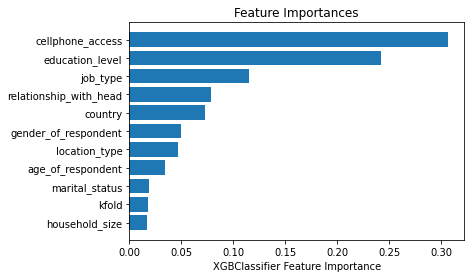

In [ ]:
model=XGBClassifier(max_depth=4, n_estimators= 150)
col_names = X_train.columns                           
model.fit(X_train, y_train.ravel())

importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('XGBClassifier Feature Importance')
plt.show()



In [ ]:
X_test

,country,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,kfold
5149,0.091692,0.178739,0.017133,0.144355,0.113353,0.189696,0.177149,0.121007,0.085451,0.131738,1
15342,0.250659,0.116503,0.183797,0.144355,0.109541,0.189696,0.177149,0.173598,0.232773,0.181481,3
8544,0.250659,0.116503,0.017133,0.140690,0.032096,0.106795,0.086586,0.121007,0.232773,0.181481,1
2327,0.114825,0.116503,0.183797,0.144355,0.173591,0.189696,0.177149,0.173598,0.085451,0.079507,0
10664,0.114825,0.116503,0.183797,0.140690,0.173591,0.189696,0.177149,0.173598,0.085451,0.079507,2
...,...,...,...,...,...,...,...,...,...,...,...
3826,0.086149,0.116503,0.017133,0.140690,0.135711,0.189696,0.177149,0.173598,0.085451,0.131738,0
21899,0.114825,0.116503,0.183797,0.112163,0.168296,0.189696,0.177149,0.173598,0.038981,0.079507,4
22939,0.114825,0.116503,0.183797,0.140690,0.173591,0.106795,0.106595,0.173598,0.085451,0.131738,4
17794,0.086149,0.116503,0.183797,0.140690,0.032096,0.106795,0.098802,0.121007,0.085451,0.131738,3


In [ ]:
model=XGBClassifier(max_depth = 4, n_estimators= 150)
model.fit(X_train, y_train.ravel())
y_pred=model.predict_proba(X_test)[:,1]
y_pred=np.where(y_pred> 0.5 , 1,0)
_auc= roc_auc_score((y_test, y_pred)
print(f'AUC:{_auc}') 

In [ ]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

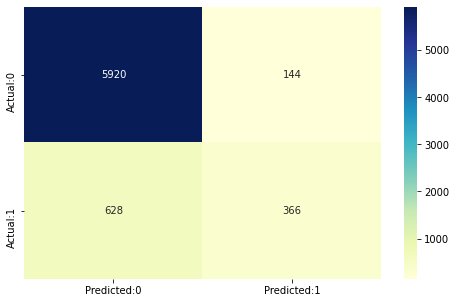

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

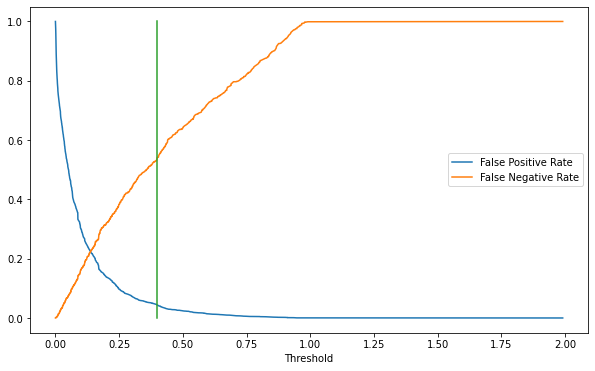

In [ ]:

fpr, tpr, thresholds = roc_curve(y_test, boost_pred)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
ax.plot([0.4,0.4],[0,1]) #mark example thresh.
#ax.set_xbound(0,0.00008); ax.set_ybound(0,0.000008) #zoom in

In [ ]:
dfplot.to_csv('threshold')

In [ ]:
encoded_df_test = pd.get_dummies(test_v2.drop(columns=['uniqueid','year']))
X_test_unknown = encoded_df_test
y_prob_unknown = model.predict_proba(X_test_unknown)[:,1]
y_pred_unknown = np.where(y_prob_unknown > 0.45, 1, 0)

,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,location_type_Urban,cellphone_access_No,cellphone_access_Yes,gender_of_respondent_Female,gender_of_respondent_Male,relationship_with_head_Child,relationship_with_head_Head of Household,relationship_with_head_Other non-relatives,relationship_with_head_Other relative,relationship_with_head_Parent,relationship_with_head_Spouse,marital_status_Divorced/Seperated,marital_status_Dont know,marital_status_Married/Living together,marital_status_Single/Never Married,marital_status_Widowed,education_level_No formal education,education_level_Other/Dont know/RTA,education_level_Primary education,education_level_Secondary education,education_level_Tertiary education,education_level_Vocational/Specialised training,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,3,30,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,7,51,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,3,77,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,6,39,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,3,16,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10081,2,62,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
10082,8,42,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
10083,1,39,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
10084,6,28,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
X_test_unknown = tsne_df_test
y_prob_unknown = model.predict_proba(X_test_unknown)[:,1]
y_pred_unknown = np.where(y_prob_unknown > 0.5, 1, 0)

In [ ]:
results = pd.DataFrame({"uniqueid":TestSet['uniqueid'],"bank_account": y_pred_unknown})


In [ ]:
results.to_csv('submission.csv', index= False)